# T-Maze with Opponent Agent

In [42]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `c:\Simulations\LAIF`


In [43]:
using RxInfer, LinearAlgebra, Plots

include("helpers.jl")
include("../goal_observation.jl")
;

## Primary Agent

In [44]:
# # Define the primary generative model
# @model function t_maze_primary(A, D, x)
#     u = datavar(Matrix{Int64}, 2) # Policy for evaluations
#     z = randomvar(2) # Latent states
#     c = datavar(Vector{Float64}, 2) # Goal prior statistics

#     z_0 ~ Categorical(D) # State prior

#     z_k_min = z_0
#     for k=1:2
#         z[k] ~ Transition(z_k_min, u[k])
#         c[k] ~ GoalObservation(z[k], A) where {
#             meta=GeneralizedMeta(x[k]), 
#             pipeline=GeneralizedPipeline(vague(Categorical,16))} # With breaker message

#         z_k_min = z[k] # Reset for next slice
#     end
# end

## Primary Simulation

In [45]:
# αs = 0.8:0.01:1.0
# S  = length(αs)
# c  = 2.0

# include("primary_agent.jl")

# Gs  = Vector{Matrix}(undef, S)
# as  = Vector{Int64}(undef, S)
# for (s, α) in enumerate(αs)
#     (A, B, C, D) = constructPrimaryABCD(α, c)
#     (infer, act) = initializePrimaryAgent(A, B, C, D)

#     a = Vector{Int64}(undef, 2)
#     o = Vector{Vector}(undef, 2)

#     Gs[s] = infer(1, a, o)
#     as[s] = act(1, Gs[s]) 
# end
# ;

In [46]:
# # Plot decision threshold of primary agent
# G_mins = zeros(S)
# for s=1:S
#     (G_mins[s], _) = findmin(skipmissing(Gs[s]))
# end
# plot(αs, G_mins, xlabel="alpha", ylabel="G_min", lw=2, color=:black, label=false)
# #scatter(αs, as)

## Secondary Agent

In [47]:
@model function t_maze_secondary(B_s, x, u)
    c = datavar(Vector{Float64})

    B ~ MatrixDirichlet(B_s)
    c ~ GoalObservation(u, B) where {
            meta=GeneralizedMeta(x),
            pipeline=GeneralizedPipeline()}
end

@constraints function structured(approximate::Bool)
    if approximate
        q(B) :: SampleList(20)
    end
end
;

## Secondary Simulation

In [48]:
c = 2.0
S = 30

include("../goal_observation.jl")
include("secondary_agent.jl")
include("secondary_environment.jl")

αs = [0.8, 0.85, 0.9, 0.95, 1.0]
L = length(αs)
eps = 0.1
B_0 = eps*ones(2, L)

(execute, observe) = initializeSecondaryWorld(αs)
(infer, act) = initializeSecondaryAgent(B_0, αs)

# Step through the experimental protocol
Bs = Vector{Matrix}(undef, S) # Posterior statistics for A
Gs = Vector{Vector}(undef, S) # Free energy values
as = Vector{Union{Int64, Missing}}(missing, S) # Actions per time
os = Vector{Union{Vector, Missing}}(missing, S) # Observations (one-hot) per time
for s = 1:S
    # reset(s) # Reset world
    (Gs[s], _) = infer(1, as[s], os[s])
         as[s] = act(Gs[s])
                 execute(as[s])
         os[s] = observe()
            
    (_, Bs[s]) = infer(2, as[s], os[s]) # Learn at t=2
end
;

In [49]:
round.(Bs[end] - B_0, digits=1)

2×5 Matrix{Float64}:
 0.0  0.0  0.0  20.0  7.0
 1.0  1.0  1.0   0.0  0.0

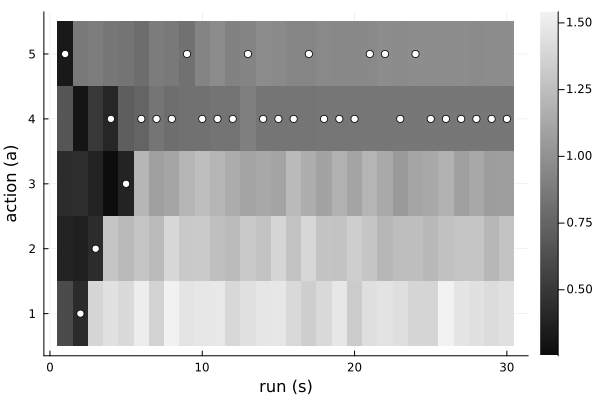

In [50]:
heatmap(hcat(Gs...), color=:grays, xlabel="run (s)", ylabel="action (a)")
scatter!(as, color=:white, label=false)